# Time Domain Future Extraction


- Author: Elmo Chavez
- Date: 18-Jul-2023

**Description**

> [...]


## Read the Dataset


Libraries


In [1]:
import mne
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Set the path to read the data


**Note:** _Use the following code when using local Environment such as Jupyter._


In [2]:
from tkinter import Tk
from tkinter.filedialog import askdirectory

root = Tk()
root.withdraw()

path = askdirectory()

root.quit()
root.destroy()

2023-08-26 14:45:10.908 python[48363:637400] +[CATransaction synchronize] called within transaction


---


### Reading Datasets


Read participants information


In [3]:
filename_part = 'participants.tsv'

df_partipants = pd.read_csv(path+'/'+filename_part, sep='\t')
df_partipants.head()

,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22


Read EEG Data


In [4]:
items = os.listdir(path+'/derivatives/')
dir_list = [item for item in items if os.path.isdir(os.path.join(path, item))]
dir_list.sort()

print('Subjects found:',len(dir_list))
print('Subjects:', dir_list[:5])

eeg_data = []

for l in dir_list:
  folder = path+'/derivatives/'+l+'/eeg/'
  f = l+'_task-eyesclosed_eeg.set'
  #print(l)
  r = mne.io.read_raw_eeglab(folder+f, preload=False, verbose='CRITICAL')
  participant_info = {'id': l}
  r.info['subject_info'] = participant_info
  eeg_data.append(r)

print('EEG Files Loaded:',len(eeg_data))

Subjects found: 88
Subjects: ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005']
EEG Files Loaded: 88


# Pre-Select EEG Datasets


Number of Subjects by Classes


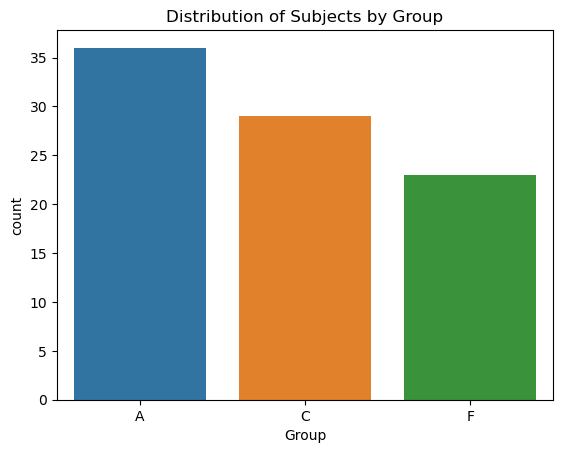

In [5]:
sns.countplot(x=df_partipants["Group"])
plt.title('Distribution of Subjects by Group')
plt.show()

Time Maximum Record by Subject


Average Max Time: 793.53


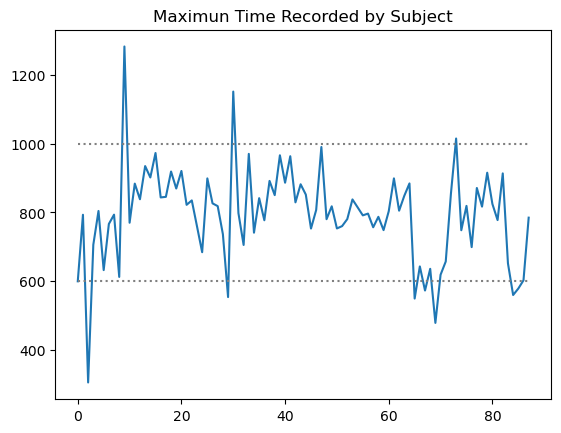

In [6]:
time_max = []

for r in eeg_data:
  time_max.append(r.tmax)

const_min = np.full(len(eeg_data),600)
const_max = np.full(len(eeg_data),1000)

print('Average Max Time:', round(np.average(time_max),2))

plt.plot(time_max)
plt.plot(const_min, linestyle='dotted', c='gray')
plt.plot(const_max, linestyle='dotted', c='gray')

plt.title('Maximun Time Recorded by Subject')
plt.show()

Select only EEG Data from Subjects of Alzheimer and Frontotemporal Dementia and limite the datasets with at least 600 seconds recorded.


In [7]:
df_partipants_ad_ftd = df_partipants[df_partipants['Group'].isin(['A','F'])]

# Encoding Gender, Groups (Classes)
gender_dict = {'M':0, 'F':1}
group_dict = {'A':0, 'F':1}

df_partipants_ad_ftd['Gender'] = df_partipants_ad_ftd['Gender'].replace(gender_dict)
df_partipants_ad_ftd['Group'] = df_partipants_ad_ftd['Group'].replace(group_dict)

print('Subjects from Alzheimer and Fronto Temporal Dementia datasets:',len(df_partipants_ad_ftd))
df_partipants_ad_ftd.head()

Subjects from Alzheimer and Fronto Temporal Dementia datasets: 59


/var/folders/42/zkw31xg11x1f6dpl9zz6hmz00000gn/T/ipykernel_48363/942251154.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partipants_ad_ftd['Gender'] = df_partipants_ad_ftd['Gender'].replace(gender_dict)
/var/folders/42/zkw31xg11x1f6dpl9zz6hmz00000gn/T/ipykernel_48363/942251154.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partipants_ad_ftd['Group'] = df_partipants_ad_ftd['Group'].replace(group_dict)


,participant_id,Gender,Age,Group,MMSE
0,sub-001,1,57,0,16
1,sub-002,1,78,0,22
2,sub-003,0,70,0,14
3,sub-004,1,67,0,20
4,sub-005,0,70,0,22


In [8]:
eeg_data_filtered = []
list_participants_id = []

for r in eeg_data:
  # Filtering EEG Data from only Alzheimer and Fronto Temporal Dementia subjects
  if r.info['subject_info']['id'] in df_partipants_ad_ftd['participant_id'].tolist():
    # Filtering EEG Datasets with at least 600 seconds of data recorded.
    if r.tmax >= 600:
      eeg_data_filtered.append(r)
      list_participants_id.append(r.info['subject_info']['id'])

df_partipants_ad_ftd = df_partipants_ad_ftd[df_partipants_ad_ftd['participant_id'].isin(list_participants_id)]
df_partipants_ad_ftd.reset_index(inplace=True, drop=True)

print('Participants Info:',len(df_partipants_ad_ftd))
print('EEG Data Subjects:',len(eeg_data_filtered))
df_partipants_ad_ftd.head()

Participants Info: 51
EEG Data Subjects: 51


,participant_id,Gender,Age,Group,MMSE
0,sub-002,1,78,0,22
1,sub-004,1,67,0,20
2,sub-005,0,70,0,22
3,sub-006,1,61,0,14
4,sub-007,1,79,0,20


Remove unused variables to free up memory space


In [9]:
del df_partipants, eeg_data, const_max, const_min, time_max, items, dir_list

# EEG Data Selected Downsampling


In [10]:
current_directory = os.getcwd()  # Get the current working directory
parent_directory = os.path.dirname(current_directory)  # Get the parent directory

In [12]:
filename = 'participants_selected.csv'
df_partipants_ad_ftd.to_csv(parent_directory+'/Training Datasets/'+filename, index=False)

# Feature Extraction


## Epochs


In [13]:
print(eeg_data_filtered[0].ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']


In [14]:
sfreq = eeg_data_filtered[0].info['sfreq']

start_time = 0
end_time = 600

duration = 60.0
overlapping = 20.0

epochs = []

for raw in eeg_data_filtered:
  ep = mne.make_fixed_length_epochs(raw.copy().crop(tmin=start_time, tmax=end_time),
                                    duration=duration, overlap=overlapping, preload=True, verbose='CRITICAL')
  epochs.append(ep)

print('Epochs created:', len(epochs[0].events))
print('Subjects with Epochs:', len(epochs))

Epochs created: 14
Subjects with Epochs: 51


**Plot Epochs from an AD Subject**


Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated


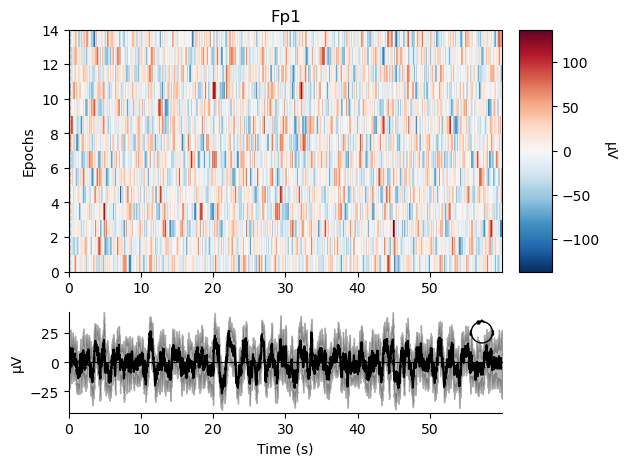

In [15]:
fig = epochs[0].plot_image(picks=['Fp1'])
plt.show()

**Plot Epochs from an FTD Subject**


In [23]:
df_partipants_ad_ftd[df_partipants_ad_ftd['Group']==1].head()

,participant_id,Gender,Age,Group,MMSE
33,sub-067,0,66,1,24
34,sub-069,0,70,1,22
35,sub-071,0,62,1,20
36,sub-072,0,65,1,18
37,sub-073,1,57,1,22


Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated


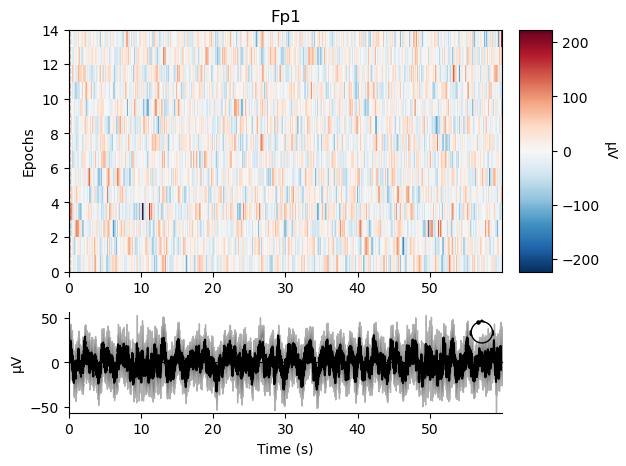

In [22]:
fig = epochs[33].plot_image(picks=['Fp1'])
plt.show()

Validate if the last epoch contain all the points


In [24]:
print('Epochs shape:',epochs[0].get_data().shape,'\n')
print('Last Epoch shape:',epochs[0].get_data()[13:,:,:].shape)

Epochs shape: (14, 19, 30000) 

Last Epoch shape: (1, 19, 30000)


## Support Functions


In [25]:
#----------------------------
# PSD Approach for All Frequencies

# Function to get PSD Features from Epochs
def PSD_Features_from_Epochs(epoch, channel_name=None, sfreq=500, fmin=0.5, fmax=50):
    features = []
    
    if channel_name==None:
        epch = epoch
    else:
        epch = epoch.copy().pick([channel_name])
    
    total_channels = len(epoch.ch_names)
    
    for ep in epch:
        
        epoch_fft = np.abs(np.fft.fft(ep))
        psd, freqs = mne.time_frequency.psd_array_welch(epoch_fft, sfreq=sfreq, verbose='CRITICAL')

        freq_mask = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_psd = psd[:, freq_mask]
        
        # Features
        total_power = np.sum(band_psd, axis=1)
        avg_power = np.mean(band_psd, axis=1)
        relative_power = np.divide(total_power, np.sum(psd, axis=1))
        peak_freq = freqs[freq_mask][np.argmax(band_psd, axis=1)]
        spectral_entropy = -np.sum(np.log(band_psd) * band_psd, axis=1)
        
        epoch_features = {}
        
        epoch_features['total_channels'] = total_channels
        epoch_features['total_power'] = np.mean(total_power)
        epoch_features['avg_power'] = np.mean(avg_power)
        epoch_features['relative_power'] = np.mean(relative_power)
        epoch_features['peak_freq'] = np.mean(peak_freq)
        epoch_features['spectral_entropy'] = np.mean(spectral_entropy)
        
        features.append(epoch_features)

    features_array = np.array([tuple(f.values()) for f in features],
                            dtype=list(zip(features[0].keys(), ['float'] * len(features[0]))))
    
    return features_array

#----------------------------
# Frequency Bands Approach

frequency_bands = {'delta': (0.5, 4),
                   'theta': (4, 8),
                   'alpha': (8, 13),
                   'beta': (13, 30),
                   'gamma': (30, 45)}

# Function to get PSD Features for each Frequency Band from Epochs
def PSD_Features_from_FreqBandas_Epochs(epoch, channel_name=None, sfreq = 500):
    features = []
    
    if channel_name==None:
        epch = epoch
    else:
        epch = epoch.copy().pick([channel_name])
    
    total_channels = len(epoch.ch_names)
    
    for ep in epch:
        
        epoch_fft = np.abs(np.fft.fft(ep))
        psd, freqs = mne.time_frequency.psd_array_welch(epoch_fft, sfreq=sfreq, verbose='CRITICAL')
        
        epoch_features = {}
        epoch_features['total_channels'] = total_channels
        
        # Features
        for band, (fmin, fmax) in frequency_bands.items():
            freq_mask = np.logical_and(freqs >= fmin, freqs <= fmax)
            band_psd = psd[:, freq_mask]
            
            total_power = np.sum(band_psd, axis=1)
            avg_power = np.mean(band_psd, axis=1)
            relative_power = np.divide(total_power, np.sum(psd, axis=1))
            peak_freq = freqs[freq_mask][np.argmax(band_psd, axis=1)]
            spectral_entropy = -np.sum(np.log(band_psd) * band_psd, axis=1)
            
            epoch_features[f'{band}_total_power'] = np.mean(total_power)
            epoch_features[f'{band}_avg_power'] = np.mean(avg_power)
            epoch_features[f'{band}_relative_power'] = np.mean(relative_power)
            epoch_features[f'{band}_peak_freq'] = np.mean(peak_freq)
            epoch_features[f'{band}_spectral_entropy'] = np.mean(spectral_entropy)
        
        features.append(epoch_features)

    features_array = np.array([tuple(f.values()) for f in features],
                            dtype=list(zip(features[0].keys(), ['float'] * len(features[0]))))
    
    return features_array

## PSD Features for Frequencies Between 1 - 50 Hz


### Feature Extraction FP1 Channel


In [26]:
fmin = 1
fmax = 50

channel = 'Fp1'

psd_features = []

for i, row in df_partipants_ad_ftd.iterrows():
    epoch = epochs[i]
    features_array = PSD_Features_from_Epochs(epoch, channel, sfreq, fmin, fmax)
    df = pd.DataFrame(features_array)
    
    df['subject_id'] = row['participant_id']
    df['age'] = row['Age']
    df['gender'] = row['Gender']
    df['group'] = row['Group']
    
    psd_features.append(df)

df_epochs_psd_features = pd.concat(psd_features)
df_epochs_psd_features.reset_index(inplace=True)
df_epochs_psd_features.rename(columns={'index':'epoch_id'}, inplace=True)
df_epochs_psd_features = df_epochs_psd_features[['subject_id','age','gender','epoch_id','total_channels','total_power','avg_power','relative_power','peak_freq','spectral_entropy','group']]

df_epochs_psd_features.head(20)

,subject_id,age,gender,epoch_id,total_channels,total_power,avg_power,relative_power,peak_freq,spectral_entropy,group
0,sub-002,78,1,0,19.0,8.138737e-07,3.255495e-08,0.480204,1.953125,0.000013,0
1,sub-002,78,1,1,19.0,6.457802e-07,2.583121e-08,0.373726,1.953125,0.000010,0
2,sub-002,78,1,2,19.0,7.862074e-07,3.144830e-08,0.397717,1.953125,0.000013,0
3,sub-002,78,1,3,19.0,8.496011e-07,3.398405e-08,0.458611,1.953125,0.000013,0
4,sub-002,78,1,4,19.0,7.503180e-07,3.001272e-08,0.402417,1.953125,0.000012,0
5,sub-002,78,1,5,19.0,7.952553e-07,3.181021e-08,0.405154,1.953125,0.000013,0
6,sub-002,78,1,6,19.0,1.075596e-06,4.302383e-08,0.513803,1.953125,0.000016,0
7,sub-002,78,1,7,19.0,1.105047e-06,4.420189e-08,0.501031,1.953125,0.000017,0
8,sub-002,78,1,8,19.0,1.064963e-06,4.259850e-08,0.479352,1.953125,0.000016,0
9,sub-002,78,1,9,19.0,8.609200e-07,3.443680e-08,0.432345,1.953125,0.000013,0


Save Dataframe as CSV file


In [28]:
filename = '1_psd_features_fp1.csv'
df_epochs_psd_features.to_csv(parent_directory+'/Training Datasets/'+filename, index=False)

### Feature Extraction All Channels


In [20]:
fmin = 1
fmax = 50

psd_features = []

for i, row in df_partipants_ad_ftd.iterrows():
    epoch = epochs[i]
    features_array = PSD_Features_from_Epochs(epoch, None, sfreq, fmin, fmax)
    df = pd.DataFrame(features_array)
    
    df['subject_id'] = row['participant_id']
    df['age'] = row['Age']
    df['gender'] = row['Gender']
    df['group'] = row['Group']
    
    psd_features.append(df)

df_epochs_psd_features = pd.concat(psd_features)
df_epochs_psd_features.reset_index(inplace=True)
df_epochs_psd_features.rename(columns={'index':'epoch_id'}, inplace=True)
df_epochs_psd_features = df_epochs_psd_features[['subject_id','age','gender','epoch_id','total_channels','total_power','avg_power','relative_power','peak_freq','spectral_entropy','group']]

df_epochs_psd_features.head(20)

,subject_id,age,gender,epoch_id,total_channels,total_power,avg_power,relative_power,peak_freq,spectral_entropy,group
0,sub-002,78,1,0,19.0,8.346040e-07,3.338416e-08,0.478456,1.953125,0.000013,0
1,sub-002,78,1,1,19.0,6.761889e-07,2.704755e-08,0.374997,1.953125,0.000011,0
2,sub-002,78,1,2,19.0,8.086165e-07,3.234466e-08,0.394570,1.953125,0.000013,0
3,sub-002,78,1,3,19.0,8.440792e-07,3.376317e-08,0.447835,1.953125,0.000013,0
4,sub-002,78,1,4,19.0,7.673421e-07,3.069369e-08,0.416419,1.953125,0.000012,0
5,sub-002,78,1,5,19.0,8.202891e-07,3.281157e-08,0.404925,1.953125,0.000013,0
6,sub-002,78,1,6,19.0,1.136704e-06,4.546814e-08,0.523462,1.953125,0.000017,0
7,sub-002,78,1,7,19.0,1.137756e-06,4.551022e-08,0.506594,1.953125,0.000017,0
8,sub-002,78,1,8,19.0,1.073014e-06,4.292054e-08,0.488081,1.953125,0.000016,0
9,sub-002,78,1,9,19.0,8.688040e-07,3.475216e-08,0.413260,1.953125,0.000013,0


Save Data Frame as a CSV File


In [21]:
filename = '1_psd_features_allch.csv'
df_epochs_psd_features.to_csv(parent_directory+'/Training Datasets/'+filename, index=False)

In [22]:
del df_epochs_psd_features

### PSD Features for Frequency Bands


In [24]:
channel = 'Fp1'
psd_features = []

for i, row in df_partipants_ad_ftd.iterrows():
    epoch = epochs[i]
    features_array = PSD_Features_from_FreqBandas_Epochs(epoch, channel, sfreq)
    df = pd.DataFrame(features_array)
    
    df['subject_id'] = row['participant_id']
    df['age'] = row['Age']
    df['gender'] = row['Gender']
    df['group'] = row['Group']
    
    psd_features.append(df)

df_epochs_psd_features = pd.concat(psd_features)
df_epochs_psd_features.reset_index(inplace=True)
df_epochs_psd_features.rename(columns={'index':'epoch_id'}, inplace=True)

df_epochs_psd_features.head(20)

,epoch_id,total_channels,delta_total_power,delta_avg_power,delta_relative_power,delta_peak_freq,delta_spectral_entropy,theta_total_power,theta_avg_power,theta_relative_power,...,beta_spectral_entropy,gamma_total_power,gamma_avg_power,gamma_relative_power,gamma_peak_freq,gamma_spectral_entropy,subject_id,age,gender,group
0,0,19.0,5.356440e-07,2.678220e-07,0.316042,1.953125,0.000008,1.703684e-08,8.518421e-09,0.010052,...,0.000001,1.292570e-07,1.615713e-08,0.076265,44.921875,2.305350e-06,sub-002,78,1,0
1,1,19.0,3.903346e-07,1.951673e-07,0.225894,1.953125,0.000006,2.239278e-08,1.119639e-08,0.012959,...,0.000002,1.108229e-07,1.385286e-08,0.064135,35.156250,1.989289e-06,sub-002,78,1,0
2,2,19.0,5.090068e-07,2.545034e-07,0.257490,1.953125,0.000008,3.471327e-08,1.735663e-08,0.017560,...,0.000002,8.779028e-08,1.097378e-08,0.044410,37.109375,1.598450e-06,sub-002,78,1,0
3,3,19.0,5.687169e-07,2.843584e-07,0.306991,1.953125,0.000008,2.759734e-08,1.379867e-08,0.014897,...,0.000001,1.364043e-07,1.705053e-08,0.073631,39.062500,2.414936e-06,sub-002,78,1,0
4,4,19.0,5.352662e-07,2.676331e-07,0.287079,1.953125,0.000008,2.820804e-08,1.410402e-08,0.015129,...,0.000001,9.871103e-08,1.233888e-08,0.052942,42.968750,1.780008e-06,sub-002,78,1,0
5,5,19.0,5.033110e-07,2.516555e-07,0.256419,1.953125,0.000007,2.448675e-08,1.224337e-08,0.012475,...,0.000001,1.072440e-07,1.340550e-08,0.054637,33.203125,1.918974e-06,sub-002,78,1,0
6,6,19.0,8.547037e-07,4.273518e-07,0.408284,1.953125,0.000012,2.504303e-08,1.252151e-08,0.011963,...,0.000002,7.512597e-08,9.390747e-09,0.035887,39.062500,1.378927e-06,sub-002,78,1,0
7,7,19.0,8.000322e-07,4.000161e-07,0.362736,1.953125,0.000011,2.414098e-08,1.207049e-08,0.010946,...,0.000002,1.199898e-07,1.499872e-08,0.054404,39.062500,2.137112e-06,sub-002,78,1,0
8,8,19.0,8.393139e-07,4.196569e-07,0.377785,1.953125,0.000012,3.054693e-08,1.527346e-08,0.013750,...,0.000002,5.670714e-08,7.088392e-09,0.025525,41.015625,1.054286e-06,sub-002,78,1,0
9,9,19.0,6.375809e-07,3.187904e-07,0.320186,1.953125,0.000009,4.010957e-08,2.005478e-08,0.020143,...,0.000002,4.017814e-08,5.022267e-09,0.020177,41.015625,7.633296e-07,sub-002,78,1,0


Save Data Frame to csv file


In [25]:
filename = '1_psd_bands_features_fp1.csv'
df_epochs_psd_features.to_csv(parent_directory+'/Training Datasets/'+filename, index=False)

In [26]:
del df_epochs_psd_features

### PSD Features for Frequency Bands All Channels


In [29]:
psd_features = []

for i, row in df_partipants_ad_ftd.iterrows():
    epoch = epochs[i]
    features_array = PSD_Features_from_FreqBandas_Epochs(epoch, None, sfreq)
    df = pd.DataFrame(features_array)
    
    df['subject_id'] = row['participant_id']
    df['age'] = row['Age']
    df['gender'] = row['Gender']
    df['group'] = row['Group']
    
    psd_features.append(df)

df_epochs_psd_features = pd.concat(psd_features)
df_epochs_psd_features.reset_index(inplace=True)
df_epochs_psd_features.rename(columns={'index':'epoch_id'}, inplace=True)

df_epochs_psd_features.head(20)

,epoch_id,total_channels,delta_total_power,delta_avg_power,delta_relative_power,delta_peak_freq,delta_spectral_entropy,theta_total_power,theta_avg_power,theta_relative_power,...,beta_spectral_entropy,gamma_total_power,gamma_avg_power,gamma_relative_power,gamma_peak_freq,gamma_spectral_entropy,subject_id,age,gender,group
0,0,19.0,5.607184e-07,2.803592e-07,0.321419,1.953125,0.000008,1.780230e-08,8.901150e-09,0.010167,...,0.000001,1.402790e-07,1.753488e-08,0.080389,41.118421,2.489644e-06,sub-002,78,1,0
1,1,19.0,4.036695e-07,2.018348e-07,0.224124,1.953125,0.000006,2.129087e-08,1.064544e-08,0.011726,...,0.000002,1.166759e-07,1.458449e-08,0.064537,35.361842,2.089541e-06,sub-002,78,1,0
2,2,19.0,5.249767e-07,2.624883e-07,0.256317,1.953125,0.000008,3.140269e-08,1.570135e-08,0.015305,...,0.000002,1.045114e-07,1.306392e-08,0.050853,37.109375,1.881548e-06,sub-002,78,1,0
3,3,19.0,5.627172e-07,2.813586e-07,0.298903,1.953125,0.000008,2.816719e-08,1.408359e-08,0.014952,...,0.000002,1.184824e-07,1.481030e-08,0.062715,37.828947,2.112341e-06,sub-002,78,1,0
4,4,19.0,5.368642e-07,2.684321e-07,0.291363,1.953125,0.000008,3.484860e-08,1.742430e-08,0.018918,...,0.000001,1.033295e-07,1.291619e-08,0.056063,39.268092,1.862132e-06,sub-002,78,1,0
5,5,19.0,5.003435e-07,2.501718e-07,0.247001,1.953125,0.000007,2.558967e-08,1.279483e-08,0.012630,...,0.000002,9.286489e-08,1.160811e-08,0.045874,35.567434,1.679065e-06,sub-002,78,1,0
6,6,19.0,8.788120e-07,4.394060e-07,0.404683,1.953125,0.000012,2.741895e-08,1.370948e-08,0.012592,...,0.000002,8.217251e-08,1.027156e-08,0.037882,39.884868,1.501249e-06,sub-002,78,1,0
7,7,19.0,7.939925e-07,3.969962e-07,0.353695,1.953125,0.000011,4.255323e-08,2.127661e-08,0.018890,...,0.000002,1.175289e-07,1.469112e-08,0.052315,39.268092,2.102089e-06,sub-002,78,1,0
8,8,19.0,8.389630e-07,4.194815e-07,0.381810,1.953125,0.000012,2.798026e-08,1.399013e-08,0.012695,...,0.000002,7.132760e-08,8.915950e-09,0.032292,38.548520,1.310140e-06,sub-002,78,1,0
9,9,19.0,6.466580e-07,3.233290e-07,0.307641,1.953125,0.000009,4.084518e-08,2.042259e-08,0.019414,...,0.000002,3.666433e-08,4.583041e-09,0.017386,40.810033,6.997175e-07,sub-002,78,1,0


Save Data Frame to csv file


In [30]:
filename = '1_psd_bands_features_allch.csv'
df_epochs_psd_features.to_csv(parent_directory+'/Training Datasets/'+filename, index=False)